# playground: stochastic-geometric 6D pose estimation

### setup of experiment

In [1]:
 # import modules from source
import os, sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np

features = {
    'p1': np.array([0, -25, -43.30]),
    'p2': np.array([100, -25, -43.30]),
    'p3': np.array([0, 61.60, -93.30]),
    'p4': np.array([100, 111.60, -6.70]),
    'p5': np.array([100, 25, 43.30]),
    'p6': np.array([0, 111.60, -6.70]),
}

features_arr = np.row_stack(list(features.values()))

C = 1000
sensors = {
    's1': np.array([C, 0, 0]),
    's2': np.array([0, 0, C]),
    's3': np.array([0, -C, 0])
}

np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)

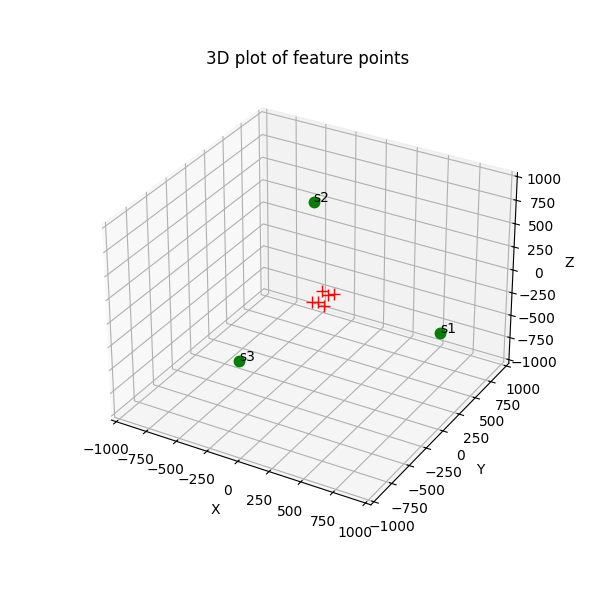

In [2]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plot feature points
for label, (x,y,z) in features.items():
    ax.plot(x,y,z, "+", markersize=8, label=label, color="r")
    # ax.text(x,y,z, label)

# plot sensors
for label, (x,y,z) in sensors.items():
    ax.plot(x,y,z, ".", markersize=15, label=label, color="g")
    ax.text(x,y,z, label)


# plot data points
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D plot of feature points')

ax.set_xlim([-C, C])
ax.set_ylim([-C, C])
ax.set_zlim([-C, C])

plt.show()

### observation function for lateration

In [13]:
from scipy.spatial.transform import Rotation
    
# rigid body transformation x,y,z-axis
def p1_xyz(z, alpha, w):
    # R_x = Rotation.from_euler('x', alpha[0])
    # R_y = Rotation.from_euler('y', alpha[1])
    # R_z = Rotation.from_euler('z', alpha[2])
    # return R_z.apply(R_y.apply(R_x.apply(z + w)))

    R_zyx = Rotation.from_euler('xyz', alpha)
    return R_zyx.apply(z+w)
    
# observational function of multilateration
def p2(z, alpha, w, gamma):
    u = p1_xyz(z, alpha, w)
    return np.linalg.norm(u-gamma)

def angle_between_vectors(v1, v2):
    # normalize the vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)

    # calculate the angle
    dot_product = np.dot(v1_norm, v2_norm)
    angle_rad = np.arccos(dot_product)
    
    return angle_rad

### Forward model (true distances):

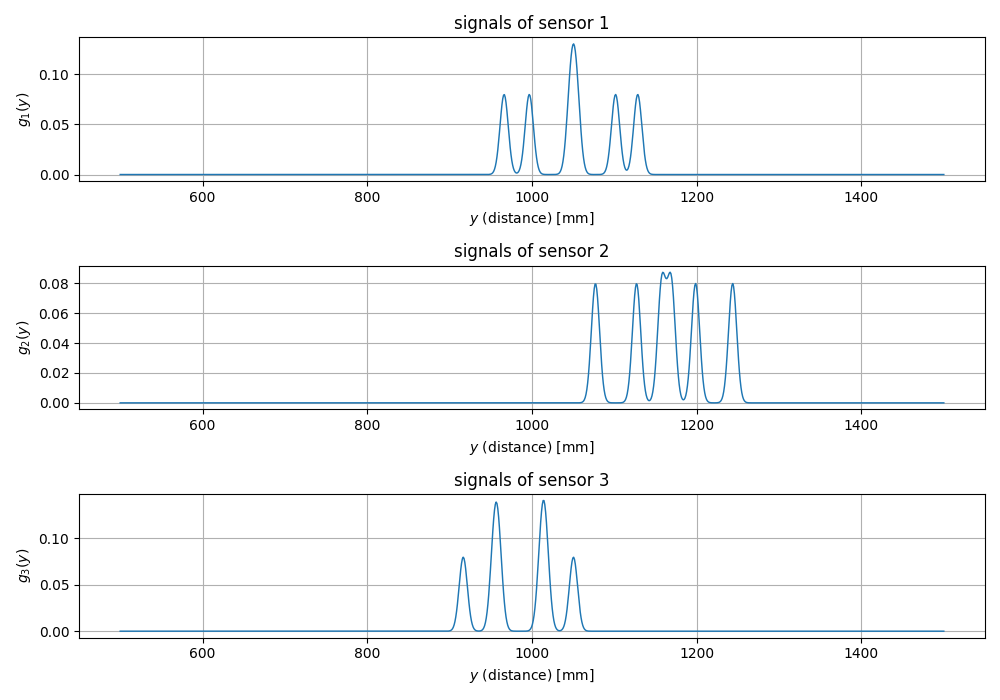

In [14]:
from scipy import interpolate

# set initial location and orientation
# w0 = features_arr.mean(axis=0)
w0 = features['p6']

roll0 = -np.pi/2
pitch0 = angle_between_vectors(np.array([0, 1.0, features['p1'][2]]) - features['p1'], features['p3'] - features['p1'])
yaw0 = 0
V0 = np.array([roll0, pitch0, yaw0])


# V0 = np.ones((3,))*np.pi*(1/3)
# w0 = np.ones((3,))*np.pi*40

true_pose = np.concatenate((V0, w0))

# plot sensor data
plt.figure(figsize=(10, 7))

y_pdfs = {}

for i, (slabel, sensor_pos) in enumerate(sensors.items()):

    distances = []
    for flabel, fvec in features.items():
        distances.append(p2(fvec, V0, w0, sensor_pos))

    x = np.linspace(500, 1500, 1000)
    y = np.zeros_like(x)
    sigma = 5
        
    for d in distances:
        # add a gaussian kernel for each distance
        gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
        y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))


    y_pdfs[slabel] = interpolate.interp1d(x, y, fill_value="extrapolate")
    
    # add a subplot for the current sensor
    plt.subplot(len(sensors), 1, i+1)
    plt.plot(x, y, linewidth=1.05)
    plt.title(f"signals of sensor {i+1}")
    plt.xlabel(fr'$y$ (distance) [mm]')
    plt.ylabel(fr'$g_{i+1}(y)$')
    plt.grid(True)

plt.tight_layout()
plt.show()


### feature coordinate mixture model

In [5]:
# draw R samples for each feature coordinate

def q(z, std, R):
    z_sampled = np.random.normal(z, std, size=(R, z.shape[0]))
    
    if (z_sampled.shape[0] == 1):
        return z_sampled[0]
    
    return z_sampled

### drawing R measurements from mixture model

In [6]:
# sample measurements for each feature point

sampled_feature_pnts = {}
R = 50
std = 10
for feature_label, feature_coords in features.items():
    sampled_feature_pnts[feature_label] = q(feature_coords, std, R)

N = len(sampled_feature_pnts)

sampled_feature_pnts

{'p1': array([[ 5.70390096e+00, -3.41330308e+01, -4.73740683e+01],
        [ 1.10087132e+01, -2.56910085e+01, -3.17816484e+01],
        [-1.20781683e+00, -9.75726876e+00, -5.41975226e+01],
        [-9.57370729e+00, -1.41531084e+01, -4.86011266e+01],
        [-3.11852746e+00, -3.63074299e+01, -2.63384821e+01],
        [-3.79775033e+00, -4.37962073e+01, -2.56759466e+01],
        [ 1.18306289e+00, -7.57889934e+00, -4.63914521e+01],
        [ 3.13430975e+00, -2.90125289e+01, -3.64816193e+01],
        [-1.04618519e+01, -1.75169945e+01, -3.86938623e+01],
        [ 9.69586231e+00, -2.38593301e+01, -4.13539288e+01],
        [ 8.30004108e+00, -3.86324697e+01, -1.61249309e+01],
        [-7.84791160e+00, -1.60316622e+01, -4.75650698e+01],
        [-1.51625650e+01, -1.49530163e+01, -5.28192311e+01],
        [ 8.23360254e+00, -1.89833738e+01, -3.91689457e+01],
        [ 1.35251908e+01, -4.11372990e+01, -2.91277163e+01],
        [-6.51364051e+00, -3.33011769e+01, -3.51818185e+01],
        [ 1.561345

In [7]:
# # calculate distances from observation functions p1,p2 and interpolate from pdf of  mixture model

# distances = {l : [] for l in sensors.keys()}
# y_pdf = {l : [] for l in sensors.keys()}

# cost_sum = 0
# for N, (feature_label, samples_arr) in enumerate(sampled_feature_pnts.items()):
#     for R, zi_vec, in enumerate(samples_arr):
#         inner_product = 1
#         for sensor_label, sensor_coords in sensors.items():
#             d = p2(zi_vec, V0, w0, sensor_coords)
#             distances[sensor_label].append(d)
#             y_pdf[sensor_label].append(y_pdfs[sensor_label](d))
#             inner_product *= y_pdf[sensor_label][-1]
            
#         cost_sum += inner_product
            
# cost_sum
# # y_pdf

In [8]:
# N = len(sampled_feature_pnts)
# R = len(sampled_feature_pnts['p1'])

# cost function
def f_cost(x0, *args):
    V, w = x0.reshape(2,3)
    
    cost_sum = 0.0
    for _, samples_arr in sampled_feature_pnts.items():
        for z_vec in samples_arr:
            inner_product = 1.0
            for sensor_label, sensor_coords in sensors.items():
                inner_product *= y_pdfs[sensor_label](p2(z_vec, V, w, sensor_coords))
                
            cost_sum += inner_product
    
    return cost_sum / (N*R)

(N, R)

(6, 50)

### Nelder-Mead

In [9]:
from scipy.optimize import minimize

true_pose = np.concatenate((V0, w0))

V_guess = q(V0, 0.17, 1)
w_guess = q(w0, 10, 1)

x0 = np.concatenate((V_guess, w_guess))
alpha_opt = minimize(f_cost, x0, method='Nelder-Mead', tol=10e-3)
alpha_opt.x

print("%s"%str(true_pose))  # real pose
print(x0)                   # perturbed pose
print(alpha_opt.x)          # predicted pose
a, b = x0.reshape(2,3)


[ -1.57079633   0.52361148   0.           0.         111.6         -6.7       ]
[ -1.357128     0.19176012  -0.314902    -5.33214911 100.71533918 -23.39658085]
[-1.44854104  0.2345385  -0.32362668 -2.68452142 96.80034476 -5.33570781]


### Bayesian Optimization

In [10]:
# draw guess pose for inital value of optimization
true_pose = np.concatenate((V0, w0))

dV_max = 0.17
dw_max = 10

V_guess = q(V0, dV_max, 1)
w_guess = q(w0, dw_max, 1)

In [11]:
from bayes_opt import BayesianOptimization

# define bounds
pbounds = {
    'V0': (V_guess[0]-dV_max, V_guess[0]+dV_max),
    'V1': (V_guess[1]-dV_max, V_guess[1]+dV_max),
    'V2': (V_guess[2]-dV_max, V_guess[2]+dV_max),
    'w0': (w_guess[0]-dw_max, w_guess[0]+dw_max),
    'w1': (w_guess[1]-dw_max, w_guess[1]+dw_max),
    'w2': (w_guess[2]-dw_max, w_guess[2]+dw_max),
}

def f_cost_wrapper(V0, V1, V2, w0, w1, w2):
    x0 = np.array([V0, V1, V2, w0, w1, w2])
    return f_cost(x0)

# create optimizer object
optimizer = BayesianOptimization(
    f=f_cost_wrapper,
    pbounds=pbounds,
    random_state=1,
)

# V_guess = q(V0, 0.17, 1)
# w_guess = q(w0, 10, 1)



optimizer.probe(
    params={"V0": V_guess[0], "V1": V_guess[1], "V2": V_guess[2], "w0": w_guess[0], "w1": w_guess[1], "w2": w_guess[2]},
    lazy=True
)
    
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

# print("Best result: ", optimizer.max)

best_params = optimizer.max['params']
best_alpha = np.array([best_params['V0'], best_params['V1'], best_params['V2'], best_params['w0'], best_params['w1'], best_params['w2']])
# best_beta = np.array([best_params['w0'], best_params['w1'], best_params['w2']])

x_guess = np.concatenate((V_guess, w_guess))

print(" True: " + str(true_pose))
print("Guess: " + str(np.concatenate((V_guess, w_guess))) + ". RMS: " + str(np.mean(np.sqrt((x_guess - true_pose)**2))))
print(" Best: " + str(best_alpha) + ". RMS: " + str(np.mean(np.sqrt((best_alpha - true_pose)**2))))



|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 1         | 1.42e-05  | -1.774    | 0.3619    | -0.04593  | 8.109     | 114.3     | -2.23     |
| 2         | 4.381e-05 | -1.802    | 0.4368    | -0.2159   | 4.156     | 107.3     | -10.38    |
| 3         | 3.486e-05 | -1.88     | 0.3094    | -0.08102  | 8.886     | 112.7     | 1.475     |
| 4         | 6.934e-05 | -1.874    | 0.4905    | -0.2066   | 11.52     | 112.7     | -1.056    |
| 5         | 3.239e-05 | -1.896    | 0.2593    | 0.05633   | 17.47     | 110.6     | 1.617     |
| 6         | 8.236e-05 | -1.646    | 0.4961    | -0.187    | -1.11     | 107.7     | 5.333     |
| 7         | 2.253e-05 | -1.91     | 0.3351    | 0.1098    | 8.773     | 118.2     | -5.919    |
| 8         | 3.751e-05 | -1.71     | 0.4757    | -0.2097   | 13.11     | 124.1     | 2.734     |
| 9         | 5.674e

In [12]:
# # # # test plot of cost function

# k=2
# # for k in range(3):

# # define ranges for V0 and w0
# V_range = np.linspace(-2.5, 2.5, 50)
# w_range = np.linspace(-50, 150, 50)

# # initialize cost surface
# cost_surface = np.zeros((len(V_range), len(w_range)))
# V, w = V0.copy(), w0.copy()
# x0 = np.concatenate((V, w))

# # calculate the cost for each combination of V0 and w0
# for i, V_ in enumerate(V_range):
#     for j, w_ in enumerate(w_range):
#         x0[k], x0[k+3] = V_, w_
#         cost_surface[i, j] = f_cost(x0)

# # from scipy.interpolate import interp2d
# from scipy.interpolate import RegularGridInterpolator

# # interp_func = interp2d(V_range, w_range, cost_surface.T, kind='cubic')
# interp_func = RegularGridInterpolator((V_range, w_range), cost_surface, bounds_error=False, fill_value=None)
# # alpha_opt_z = interp_func(alpha_opt.x[:3][k], alpha_opt.x[3:][k])[0]
# true_pose_z = interp_func((true_pose[:3][k], true_pose[3:][k]))
# bayes_z = interp_func((best_alpha[:3][k], best_alpha[3:][k]))

# # plotting the cost surface
# V_mesh, w_mesh = np.meshgrid(V_range, w_range)

# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(111, projection='3d')

# # ax.scatter(alpha_opt.x[:3][1], alpha_opt.x[3:][1], alpha_opt_z, color='red', s=100, marker='x')
# # ax.scatter(true_pose[:3][1], true_pose[3:][1], true_pose_z, color='green', s=100, marker='x')
# # ax.plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
# ax.plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)
# ax.plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, color='cyan', marker='x', markersize=10, zorder=100)

# ax.plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis')

# ax.set_xlabel('V')
# ax.set_ylabel('w')
# ax.set_zlabel('Cost Sum')
# ax.view_init(azim=-90, elev=90)
# plt.title('Cost Function')

# plt.show()

In [13]:
# from scipy.interpolate import interp2d

# fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(18, 6))

# for k in [0, 1, 2]:

#     # define ranges for V0 and w0
#     Vk_range = np.linspace(-2.5, 2.5, 50)
#     wk_range = np.linspace(-50, 150, 50)

#     # initialize cost surface
#     cost_surface = np.zeros((len(Vk_range), len(wk_range)))

#     # calculate cost for each combination of V0 and w0
#     for i, Vk_ in enumerate(Vk_range):
#         for j, wk_ in enumerate(wk_range):
#             V, w = V0.copy(), w0.copy()
#             V[k], w[k] = Vk_, wk_

#             x0 = np.concatenate((V, w))
#             cost_surface[i, j] = f_cost(x0)

#     # interpolate markers
#     interp_func = interp2d(Vk_range, wk_range, cost_surface.T, kind='cubic')
#     # alpha_opt_z = interp_func(alpha_opt.x[:3][k], alpha_opt.x[3:][k])[0]
#     true_pose_z = interp_func(true_pose[:3][k], true_pose[3:][k])[0]
#     bayes_z = interp_func(best_alpha[:3][k], best_alpha[3:][k])[0]
    
    
#     # plot cost surface
#     V_mesh, w_mesh = np.meshgrid(Vk_range, wk_range)
#     axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

#     # plot markers
#     # axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
#     axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)
#     axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, color='cyan', marker='x', markersize=10, zorder=100)

#     axes[k].set_xlabel('V')
#     axes[k].set_ylabel('w')
#     axes[k].set_zlabel('Cost Sum')
#     axes[k].set_title(f'Cost Function for k={k}')

# plt.tight_layout()
# plt.show()

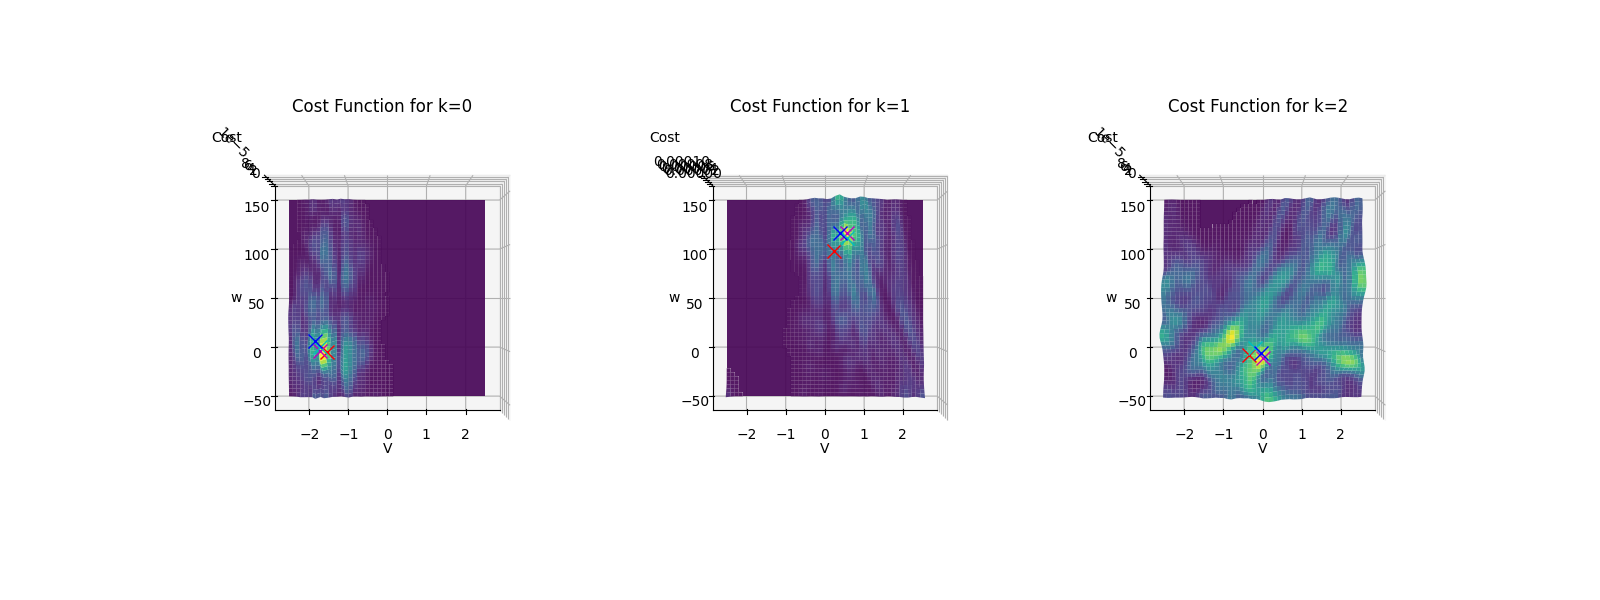

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Process, Queue

# computes cost surface for given k
def compute_cost_surface(k, V0, w0, f_cost, alpha_opt, true_pose, best_alpha, guess, output):
    V_range = np.linspace(-2.5, 2.5, 50)
    w_range = np.linspace(-50, 150, 50)

    # initialize cost surface
    cost_surface = np.zeros((len(V_range), len(w_range)))
    V, w = V0.copy(), w0.copy()
    x0 = np.concatenate((V, w))

    # calculate cost for each combination of V0 and w0
    for i, V_ in enumerate(V_range):
        for j, w_ in enumerate(w_range):
            x0[k], x0[k+3] = V_, w_
            cost_surface[i, j] = f_cost(x0)

    # interp_func = interp2d(V_range, w_range, cost_surface.T, kind='cubic')
    interp_func = RegularGridInterpolator((V_range, w_range), cost_surface, bounds_error=False, fill_value=None)
    
    alpha_opt_z = interp_func((alpha_opt.x[:3][k], alpha_opt.x[3:][k]))
    true_pose_z = interp_func((true_pose[:3][k], true_pose[3:][k]))
    bayes_z = interp_func((best_alpha[:3][k], best_alpha[3:][k]))
    guess_z = interp_func((guess[0][k], guess[1][k]))

    # put results in output queue
    output.put((k, cost_surface, alpha_opt_z, true_pose_z, bayes_z, guess_z))

# create queue to share results
output = Queue()
processes = []

for k in range(3):
    p = Process(target=compute_cost_surface, args=(k, V0, w0, f_cost, alpha_opt, true_pose, best_alpha, (V_guess, w_guess), output))
    processes.append(p)
    p.start()

# wait for processes to complete
for p in processes:
    p.join()

results = [output.get() for _ in range(3)]


# plot results
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(16, 6))
for result in sorted(results):
    k, cost_surface, alpha_opt_z, true_pose_z, bayes_z, guess_z = result
    
    # interpolate and plot cost surface
    V_range = np.linspace(-2.5, 2.5, 50)
    w_range = np.linspace(-50, 150, 50)
    V_mesh, w_mesh = np.meshgrid(V_range, w_range)
    axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

    # plot markers
    axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, 'rx', markersize=10, zorder=5)
    axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, 'mx', markersize=10, zorder=5)
    axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, 'cx', markersize=10, zorder=5)
    axes[k].plot(V_guess[k], w_guess[k], guess_z, 'bx', markersize=10, zorder=5)

    axes[k].set_xlabel('V')
    axes[k].set_ylabel('w')
    axes[k].set_zlabel('Cost')
    axes[k].set_title(f'Cost Function for k={k}')
    axes[k].view_init(azim=-90, elev=90)
plt.show()
